In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Carga Datos

In [13]:
tipos = {"fecha": str, "hora": int, "temperatura": float, "humedad": float, "presion": float, "direccion_viento": float, "velocidad_viento": float, "estacion": str}
data = pd.read_csv("clima_bsas.csv",dtype=tipos)
del data["Unnamed: 0"]
data.head(2)

,fecha,hora,temperatura,humedad,presion,direccion_viento,velocidad_viento,estacion
0,01062021,0,16.7,53.0,1012.6,290.0,15.0,AEROPARQUE AERO
1,01062021,1,15.5,66.0,1012.1,320.0,9.0,AEROPARQUE AERO


In [14]:
print(data.shape)
data.dtypes

(87280, 8)


fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
estacion             object
dtype: object

# Preparación datos

In [15]:
print(data.shape)
datana = data.dropna()
datana.shape

(87280, 8)


(87251, 8)

In [16]:
aero = datana[datana["estacion"] == "AEROPARQUE AERO"].copy()
aero.shape
del aero["estacion"]
aero.dtypes

fecha                object
hora                  int64
temperatura         float64
humedad             float64
presion             float64
direccion_viento    float64
velocidad_viento    float64
dtype: object

In [17]:
aero["fecha"] = pd.to_datetime(aero["fecha"],format="%d%m%Y") #+  pd.to_timedelta(aero.hora, unit='h')
aero["dia"] = aero["fecha"].dt.day
aero["mes"] = aero["fecha"].dt.month
aero["año"] = aero["fecha"].dt.year
aero.sort_values(by=["fecha"],inplace=True)
aero.reset_index(inplace=True)
promedios_aero = aero.groupby("fecha").mean().reset_index().sort_values(by="fecha")
del promedios_aero["index"]
aero.dtypes

index                        int64
fecha               datetime64[ns]
hora                         int64
temperatura                float64
humedad                    float64
presion                    float64
direccion_viento           float64
velocidad_viento           float64
dia                          int64
mes                          int64
año                          int64
dtype: object

In [18]:
aero_prom = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom")
del aero_prom["hora_prom"]
del aero_prom["index"]
aero_prom.sort_values(by=["fecha","hora"],inplace=True)


In [23]:
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(-1,unit="day")
predictor = aero.join(promedios_aero.set_index("fecha"),on="fecha",rsuffix="_prom_dia_sig")
del predictor["index"]
del predictor["hora_prom_dia_sig"]
del predictor["mes_prom_dia_sig"]
del predictor["dia_prom_dia_sig"]
del predictor["año_prom_dia_sig"]
predictor.dropna(inplace=True)
predictor.sort_values(by="fecha",inplace=True)
promedios_aero["fecha"] = promedios_aero["fecha"] + pd.Timedelta(1,unit="day")



# Modelos predecir temperatura

In [24]:
predictor.columns

Index(['fecha', 'hora', 'temperatura', 'humedad', 'presion',
       'direccion_viento', 'velocidad_viento', 'dia', 'mes', 'año',
       'temperatura_prom_dia_sig', 'humedad_prom_dia_sig',
       'presion_prom_dia_sig', 'direccion_viento_prom_dia_sig',
       'velocidad_viento_prom_dia_sig'],
      dtype='object')

In [67]:
from sklearn.model_selection import train_test_split

class ModeloSKL:
    def __init__(self)-> None:
            pass
    def setear_modelo(self,modelo,**kwargs):
        self.modelo = modelo(**kwargs)
        self.modelo.fit(self.x_train, self.y_train)
        return {"test":self.modelo.score(self.x_test,self.y_test),"train":self.modelo.score(self.x_train,self.y_train)}

    def splitear(self, a_predecir, split_train: float=0.15,dataset: pd.DataFrame=predictor,datos:list =['mes','dia','hora', 'temperatura', 'humedad', 'presion','direccion_viento', 'velocidad_viento']):
        self.split_train = split_train
        self.dataset = dataset
        self.datos_cargados = datos
        self.a_predecir = a_predecir

        x = []
        y = []
        f = []
        for grupo,df in dataset.groupby("fecha"):
            x.append(df[datos].to_numpy().flatten())
            if len(x[-1]) != 24 * len(datos):
                x.pop()
                continue
            y.append(df[a_predecir].iloc[0])
            f.append(grupo)
                
        assert(len(y) == len(x) and len(x) == len(f))
        
        self.x_train, self.x_test, self.y_train, self.y_test, self.f_train, self.f_test = train_test_split(x,y,f,test_size=split_train)

    def predecir(self, x):
        return self.modelo.predict(x)

    def plotear_perf(self):
        l = list(zip(self.f_test,self.x_test,self.y_test,strict=True))
        l.sort(key=lambda x: x[0])
        l = [list(t) for t in zip(*l)]
        f = l[0]
        x = l[1]
        y = l[2]
        plt.figure()
        plt.plot(f, y, c="blue", label="data",linewidth=1)
        plt.plot(f, self.modelo.predict(x), color="red", label="prediccion", linewidth=1)
        plt.xlabel("data")
        plt.ylabel("target")
        plt.legend()
        plt.show()


In [68]:
modelo = ModeloSKL()
modelo.splitear('temperatura_prom_dia_sig')


{'test': 0.7184363909132797, 'train': 0.8026678487250413}


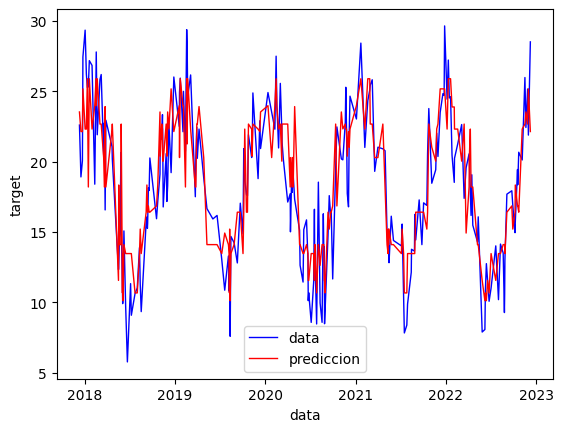

In [71]:
import sklearn.tree
from sklearn.tree import DecisionTreeRegressor

print(modelo.setear_modelo(DecisionTreeRegressor,max_depth=5))
modelo.plotear_perf()
tree = modelo.modelo

{'test': 0.2168757210017891, 'train': 0.3401177785244248}


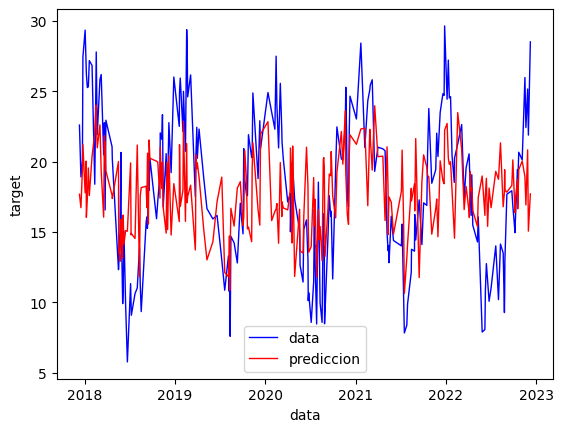

In [74]:
from sklearn.neighbors import KNeighborsRegressor
print(modelo.setear_modelo(KNeighborsRegressor,n_neighbors=10))
modelo.plotear_perf()
knn = modelo.modelo

{'test': -1.7881442104718213, 'train': 0.3011691808181749}


/home/sebastian/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


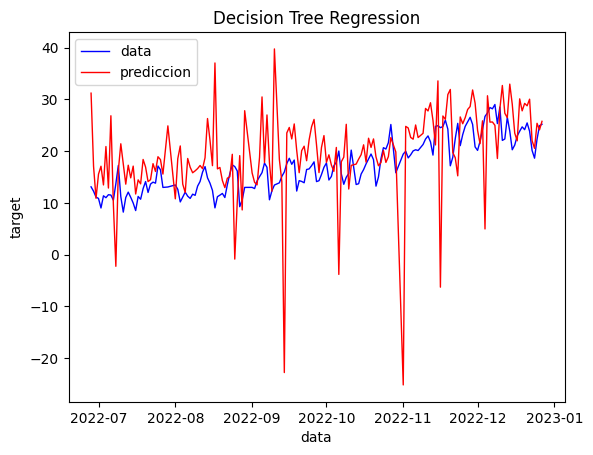

MLPRegressor()

In [ ]:
from  sklearn.neural_network import MLPRegressor
modelo_skl(MLPRegressor)